## Setup & Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "drive/MyDrive/266/w266-project/"

/content/drive/MyDrive/266/w266-project


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 7.3 MB/s 
     |████████████████████████████████| 895 kB 49.4 MB/s 
     |████████████████████████████████| 3.3 MB 58.3 MB/s 
     |████████████████████████████████| 636 kB 48.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#Imports
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer, get_linear_schedule_with_warmup

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import time
import datetime
import random



## Data

In [ ]:
#Read in amharic data

amharic_data = pd.read_csv('data/amharic/amharic_train.csv')

#Read in synthetic data
#amharic_data = pd.read_csv('data/new_amharic.csv')

#Filter synthetic data out of train
amharic_train = amharic_data[ pd.notna(amharic_data.id) ]
amharic_train

,id,tweet,subtask_a
0,14128,ሙሌ በርታ,OFF
1,28647,ከነሱ በፊት በመጡት ፈላሾች በመገፋታቸዉ አክሱም ላይ ብቻ መወሰናቸው,NOT
2,29559,አቦ ሚኪ ክፉ ቃል እኮ አየወጣሽም,NOT
3,24874,ምን አለ ያኔ ጨርሶ በነበር ሰላማችን የበዛ ይሆን ነበር,NOT
4,10355,የማደንቅሽ መስከረም አበራ ይዶር አብይ አስተዳደር ማለት ይህ ነው ኢትዮጵ...,OFF
...,...,...,...
28995,17144,እዴት ይረሳል ይህ ግዜ ዛሪ ያዙኘ ልቀቁኘ እያለ ዘራፈ ይልብናል አስቴረ ...,OFF
28996,5771,ክትፎ የጉራጌ ነው ግን ለመስቀል ጋሽ በቄም ጃዋርም መብላት ይችላሉ,NOT
28997,26328,ሰይጣን የሰይጣን ቆራጭ በሌብነት ያደግ የድሀ ልጅ,OFF
28998,4604,ድንቅ ነህ,NOT


In [ ]:
#Filter to just the new synthetic data
#amharic_synthetic = amharic_data[ pd.isna(amharic_data.id) ]
#amharic_synthetic

In [ ]:
#Read in OLID data

turkish = pd.read_csv("data/Turkish/train.tsv", sep="\t")
greek = pd.read_csv("data/Greek/train.tsv", sep="\t")
english = pd.read_csv("data/olid/olid-training-v1.0.tsv", sep="\t")
danish = pd.read_csv("data/Danish/train.tsv", sep="\t")
arabic_test = pd.read_csv("data/Arabic/test.tsv", sep="\t")
arabic = pd.read_csv("data/Arabic/train.tsv", sep="\t")

In [ ]:
#Split the train data into train/dev sets
amharic_train, amharic_dev = train_test_split(amharic_train, train_size=0.9)
print(amharic_train.shape)
print(amharic_dev.shape)

(26100, 3)
(2900, 3)


In [ ]:
#Read in test
amharic_test = pd.read_csv("data/amharic/amharic_test_reserve.csv")

#Creating new column with 0/1
amharic_test["label"] = np.nan
amharic_test.loc[(amharic_test["subtask_a"] == "OFF"), "label"] = 1
amharic_test.loc[(amharic_test["subtask_a"] == "NOT"), "label"] = 0

amharic_test

,id,tweet,subtask_a,label
0,2767,ገራሚ ትዝብት ነው,NOT,0.0
1,19212,ወድፕፊት እትዮጵያን መግዛት አይችሉም መሆንም አይገባቸውም ምክንያቱም ለኢ...,OFF,1.0
2,15530,ይቺ የበሽተኛ ልጅ,OFF,1.0
3,25421,ታዴ አንተ እኮ የሰውነት የውሀ ልክ ነህ እኔም ትንሽ የሆነ ነገር ብዬ ነ...,OFF,1.0
4,26281,ቅቅቅቅቅ ጎጠኛ ሌባ,OFF,1.0
...,...,...,...,...
995,21228,ዳኝ እንድክ ፀረ ህገ መንግስ ትወናለህ ብዬ አለምኔኩምትግርኛ ለምን በ ...,NOT,0.0
996,20165,አማራ እንደ አብን ቁርጠኛ የፖለቲካ አመራሮች በማጣቱ ምክንያት በኦሮምያ ...,NOT,0.0
997,2372,አማራ ንቃ እንደ ኪራይ እቃ መቸም አትነቃ ከነቃን ግን በተባበረ ክንዳችን...,OFF,1.0
998,20424,ይቅርታ ሰዎች ብዙ ችግር እንዳለው ባውቅም የመጣውም የኛው ሰዎችም ገረድ...,OFF,1.0


In [ ]:
#Print ratio of offensive text / total text
print(np.sum(amharic_data.subtask_a=="OFF")/np.size(amharic_data.subtask_a), "is the ratio of offensive to total tweets in the train/dev set")

0.5061379310344828 is the ratio of offensive to total tweets in the train/dev set


In [ ]:
#Get ratio for all datasets
#[arabic, english, danish, greek, turkish, amharic_synthetic, amharic_train]
all = arabic.append([english, danish, greek, turkish, amharic_train])

In [ ]:
print(np.sum(all.subtask_a=="OFF")/np.size(all.subtask_a), "is the ratio of offensive to total tweets in all the sets")

0.32165476844224783 is the ratio of offensive to total tweets in all the sets


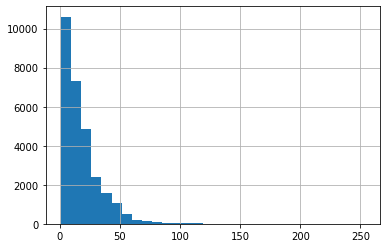

In [ ]:

# get length of all the messages in the data set
seq_len = [len(i.split()) for i in amharic_data.tweet]

pd.Series(seq_len).hist(bins = 30)

#It looks like the max length peters out after 50 although it goes up to 250 length for regular amharic train

## Preparing to run BERT

In [ ]:
#From https://mccormickml.com/2019/07/22/BERT-fine-tuning/

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
#Use Davlan mBERT since regular mBERT does not use Amharic in training, Davlan does pretraining on Amharic with mBERT
#From: https://huggingface.co/Davlan/bert-base-multilingual-cased-finetuned-amharic
tokenizer = BertTokenizer.from_pretrained('Davlan/bert-base-multilingual-cased-finetuned-amharic')


In [ ]:
#Look at lengths of the token sequences, are they any different?

max_len = 0
lengths = []

# For every sentence...
for tweet in amharic_data.tweet:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    lengths.append(len(input_ids))

print('Max tweet length: ', max_len) 
#Found max_len to be 342, which is much higher than the 250 count we saw earlier. Token sequences are longer than word sequences

Max tweet length:  342


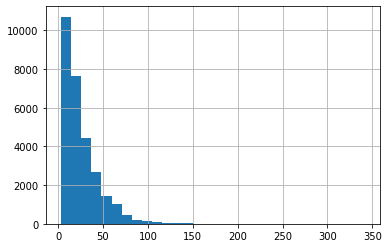

In [ ]:
# get length of all the messages in the train set

pd.Series(lengths).hist(bins = 30)

In [ ]:
#Some hyperparameters

L_RATE = 0.000005 
MAX_LEN = 55

NUM_EPOCHS = 3
BATCH_SIZE = 16

In [ ]:
#Re-using functions from Josh's XLMR notebook
def create_tensors( all_training_sets ):
    
    _all_labels = []
    _all_input_ids = []
    _all_attn_masks = []
    
    for t_set in all_training_sets:
        new_ids, new_masks, new_labels = tokenize_dataset(t_set)
        _all_input_ids = [*_all_input_ids, *new_ids]
        _all_attn_masks = [*_all_attn_masks, *new_masks]
        _all_labels = [*_all_labels, *new_labels]
        
    # Convert each Python list of Tensors into a 2D Tensor matrix.
    _all_input_ids = torch.cat(_all_input_ids, dim=0)
    _all_attn_masks = torch.cat(_all_attn_masks, dim=0)

    # Cast the labels list to a Tensor.
    _all_labels_tensor = torch.tensor(_all_labels)
    
    return _all_input_ids, _all_attn_masks, _all_labels_tensor, _all_labels

def tokenize_dataset( training_set ):
    
    _labels = []
    _ids = []
    _masks = []
    
    # look through all records
    for index, row in training_set.iterrows():
        encoded_dict = tokenizer.encode_plus(
                    row['tweet'], # Sentence to encode.
                    add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                    max_length = MAX_LEN,           # Pad or truncate.
                    padding = 'max_length',
                    return_attention_mask = True,   # Construct attn. masks.
                    return_tensors = 'pt', # Return pytorch tensors.
                    truncation = True    #use to avoid warning      
                   )

        # Add this example to our lists.
        _ids.append(encoded_dict['input_ids'])
        _masks.append(encoded_dict['attention_mask'])
        #print(row['label'])
        #_labels.append(row['label'])
        if row['subtask_a'] == 'NOT':
            _labels.append(0)
        else:
            _labels.append(1)
    
    return _ids, _masks, _labels

#Change the datasets depending on what data I want to use in the finetuning

#datasets = [amharic_synthetic, amharic_train]
#datasets = [arabic, english, danish, greek, turkish, amharic_synthetic, amharic_train]
datasets = [amharic_train]
train_input_ids, train_attn_masks, train_labels_tensor, train_labels = create_tensors(datasets)


print('   DONE. {:,} examples.'.format(len(train_labels)))

   DONE. 26,100 examples.


In [ ]:
#Dev dataset

datasets = [amharic_dev]
val_input_ids, val_attn_masks, val_labels_tensor, val_labels = create_tensors(datasets)

print('   DONE. {:,} examples.'.format(len(val_labels)))

In [ ]:
#Test dataset

datasets = [amharic_test]
test_input_ids_amharic, test_attn_masks_amharic, test_labels_amharic_tensor, test_labels_amharic = create_tensors(datasets)

print('   DONE. {:,} examples.'.format(len(test_labels_amharic)))

   DONE. 1,000 examples.


In [ ]:
#Re-using functions from Josh's XLMR notebook

# Construct a TensorDataset from the encoded examples.
prediction_dataset = TensorDataset(test_input_ids_amharic, test_attn_masks_amharic, test_labels_amharic_tensor)

# And a dataloader for handling batching.
prediction_dataloader = DataLoader(prediction_dataset, batch_size=BATCH_SIZE)

In [ ]:
#From Josh's XLMR notebook & https://mccormickml.com/2019/07/22/BERT-fine-tuning/

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(train_input_ids, train_attn_masks, train_labels_tensor)

#Creating val dataset
val_dataset = TensorDataset(val_input_ids, val_attn_masks, val_labels_tensor)


# Create the DataLoaders for our training sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 

#May want to select different model
model = BertForSequenceClassification.from_pretrained(
    "bert_save", #saved model from training on Amharic news
    #"Davlan/bert-base-multilingual-cased-finetuned-amharic",
    num_labels = 2
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert_save were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert_save and are newly initialized

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# From https://mccormickml.com/2019/07/22/BERT-fine-tuning/
# Get all of the model's parameters as a list of tuples.

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = L_RATE, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * NUM_EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
#From https://mccormickml.com/2019/07/22/BERT-fine-tuning/


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, NUM_EPOCHS):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, NUM_EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        #print(b_labels)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        (loss, logits) = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels, return_dict=False)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels, return_dict=False)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  1,632.    Elapsed: 0:00:05.
  Batch    80  of  1,632.    Elapsed: 0:00:10.
  Batch   120  of  1,632.    Elapsed: 0:00:15.
  Batch   160  of  1,632.    Elapsed: 0:00:20.
  Batch   200  of  1,632.    Elapsed: 0:00:25.
  Batch   240  of  1,632.    Elapsed: 0:00:30.
  Batch   280  of  1,632.    Elapsed: 0:00:35.
  Batch   320  of  1,632.    Elapsed: 0:00:40.
  Batch   360  of  1,632.    Elapsed: 0:00:45.
  Batch   400  of  1,632.    Elapsed: 0:00:50.
  Batch   440  of  1,632.    Elapsed: 0:00:56.
  Batch   480  of  1,632.    Elapsed: 0:01:01.
  Batch   520  of  1,632.    Elapsed: 0:01:06.
  Batch   560  of  1,632.    Elapsed: 0:01:11.
  Batch   600  of  1,632.    Elapsed: 0:01:16.
  Batch   640  of  1,632.    Elapsed: 0:01:21.
  Batch   680  of  1,632.    Elapsed: 0:01:26.
  Batch   720  of  1,632.    Elapsed: 0:01:31.
  Batch   760  of  1,632.    Elapsed: 0:01:36.
  Batch   800  of  1,632.    Elapsed: 0:01:41.
  Batch   840  of

### Training Eval

In [ ]:
#Summary of the training

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.66,0.64,0.62,0:03:26,0:00:05
2,0.62,0.63,0.64,0:03:26,0:00:05
3,0.58,0.63,0.65,0:03:26,0:00:05


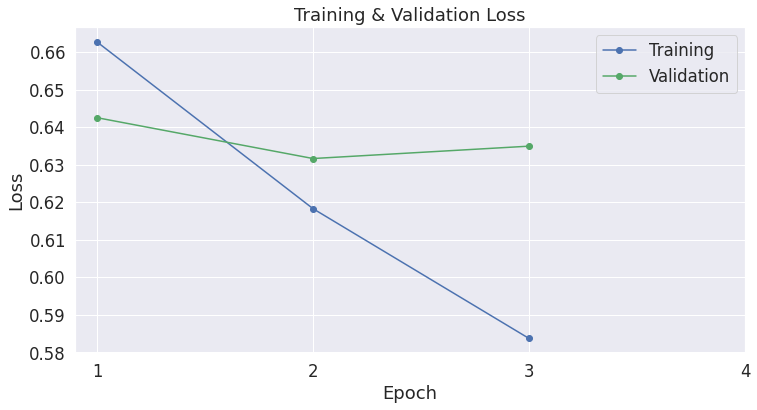

In [ ]:
% matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Predict on the validation and output the predictions for EDA


# Prediction on test set

#print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []
val_inputs = []

# Predict 
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  #val_inputs.append(b_input_ids.to('cpu').numpy())

print('    DONE.')

    DONE.


In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# For each sample, pick the label (0, 1) with the highest score.
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# Tally the number of correct predictions to get our accuracy.
accuracy = (predicted_labels == flat_true_labels).mean()

print('mBERT validation accuracy for amharic: {:.3f}'.format(accuracy))

mBERT validation accuracy for amharic: 0.648


In [ ]:
score = f1_score(flat_true_labels, predicted_labels)
print('mBERT Prediction f1 score for amharic: {:.3f}'.format(score))

mBERT Prediction f1 score for amharic: 0.677


In [ ]:
amharic_dev['predicted_label'] = predicted_labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
amharic_dev

,id,tweet,subtask_a,predicted_label
27833,13002,የት አባቱ በዱላ መከሽከሽ ነበር እንዲያስታውስ,OFF,1
13667,4911,በተለያየ የስራ ቦታ የሚገኙ ባለትዳሮችን ለማገናኘት ሲባል የመንግስት ሰራ...,NOT,0
21237,29377,እንዴት ሰው ታጣ ለዚህ ባንዳ ወይኔ,NOT,1
22333,5533,በዚህ ድህነት ላይ አንበጣ በጣም ያሳዝናል ብዙ ውድመት ሳያስከትል እግዛብ...,NOT,0
11082,29486,ትክክል ሚኩ,NOT,0
...,...,...,...,...
13644,18519,አንተ ምርጥ አህያ መፃፍ ማወቅ እዳይመስልህ ይች ሀገር እዳንተ ጠማማ ሰዎ...,OFF,1
15733,13067,ይሄ ነው ዋጋቸው,OFF,1
22887,16907,ማሽ አላህ እንደዛሬው ደስ ብሎኝ አያውቅም,NOT,0
4694,26622,አንችን ብሎ በአማራ ዘውግ ውሰጥ ተዘፍቀሽ አይደለም እንደ ግን መብትሸ ...,OFF,1


In [ ]:
#Write out these predictions to do some EDA
#amharic_dev.to_csv("amharic_dev_predictions_synt.csv")

## Test Evaluation

In [ ]:
# Prediction on test set

#print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# For each sample, pick the label (0, 1) with the highest score.
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# Tally the number of correct predictions to get our accuracy.
accuracy = (predicted_labels == flat_true_labels).mean()

print('mBERT Prediction accuracy for amharic: {:.3f}'.format(accuracy))

mBERT Prediction accuracy for amharic: 0.677


In [ ]:
score = f1_score(flat_true_labels, predicted_labels)
print('mBERT Prediction f1 score for amharic: {:.3f}'.format(score))

mBERT Prediction f1 score for amharic: 0.700
